In [128]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize

In [129]:
def plot_particle(pos, vel=[]):
    plt.scatter(*pos.T)
    if vel !=[]:
        plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.xlim(0,1)
    plt.ylim(0,1)
    

In [164]:
# スキーム
def distance_matrix(pos):
    n_sample, dim = pos.shape
    
    distance_mtx = np.zeros([n_sample, n_sample])
    for i in range(n_sample):
        for j in range(n_sample):
            dist = np.linalg.norm(pos[i] - pos[j])
            distance_mtx[i,j] = dist
    
    return distance_mtx


def weight_matrix(pos, r_e):
    distance_mtx = distance_matrix(pos)
    weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)
    
    return weight_mtx


def laplacian_u(val, n_0, lambda_0, weight):
    n_sample, dim = val.shape
    
    laplacian = np.empty([n_sample, dim])
    for i, v in enumerate(val):
        w = np.repeat([weight[i]], dim, axis=0).T
        laplacian[i] = (2*dim)/(lambda_0*n_0) * sum((val - v)* w)
    
    return laplacian


def laplacian_p(press, n_0, lambda_0, weight_mtx):
    n_sample = len(press)
    dim = 2
    
    laplacian = np.empty(n_sample)
    for i, p in enumerate(press):
        w = weight_mtx[i]
        laplacian[i] = (2*dim)/(lambda_0*n_0) * sum((press - p)* w)
    
    return laplacian

def grad_p(press, n_0, pos, distance_mtx, weight_mtx):
    n_sample = len(press)
    dim = 2
    
    grad = np.empty([n_sample, dim])
    for i, p in enumerate(press):
        w = weight_mtx[i]
        d = distance_mtx[i]
        ps = pos[i]
        
        a = np.repeat([(press - p)/d **2], 2, axis=0).T
        b = np.repeat([w], 2, axis=0).T
        
        c = a * (pos - ps)* b
        c[np.isnan(c)] = 0 # d=0のときにnanが出るので除外する
        grad[i] = dim/n_0 * np.sum(c, axis=0)
        
    return grad

(60, 2)

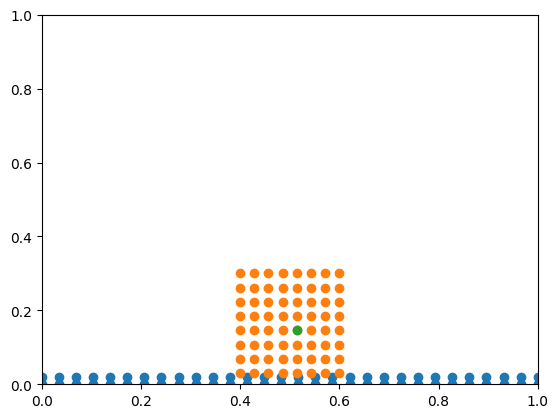

In [209]:
# 初期条件
### 固定壁
x = np.linspace(0, 1, 30)
y = np.linspace(0, 0.02, 2)
xx, yy = np.meshgrid(x, y)
pos_rigid = np.block([[xx.flatten()], [yy.flatten()]]).T
n_sample, dim = pos_rigid.shape
vel_rigid = np.zeros([n_sample, dim])
pttype_rigid = np.ones(n_sample)

### 水柱
x = np.linspace(0.4, 0.6, 8)
y = np.linspace(0.03, 0.3, 8)
xx, yy = np.meshgrid(x, y)

pos_water = np.block([[xx.flatten()], [yy.flatten()]]).T
n_sample, dim = pos_water.shape
vel_water = np.ones([n_sample, dim])*0.0
pttype_water = np.zeros(n_sample)

# 結合
pos_rigid.shape, pos_water.shape
pos = np.block([[pos_rigid], [pos_water]])
vel = np.block([[vel_rigid], [vel_water]])
point_type = np.block([pttype_rigid, pttype_water])
n_sample, dim = pos.shape

#圧力の初期化
p=np.ones(n_sample)*1+1000

# 描画
plot_particle(pos[:60])
plot_particle(pos[60:])

representive_index = 88
plot_particle(pos[representive_index]) # 代表位置
vel_rigid.shape

In [210]:
### 解析条件
#時間 
dT = 0.001
t_max = 2

# パラメータ
r_e = 0.05
nu = 1E-6
rho = 1000
g = [0, -9.80665]
alpha = 0.2

# 初期点群の距離，重みの計算
init_distance_mtx = distance_matrix(pos)
init_weight_mtx = weight_matrix(pos, r_e)

# 各点の粒子数密度，分散
n_ = np.sum(init_weight_mtx, axis=1)
lambda_ =  np.sum(init_distance_mtx **2 * init_weight_mtx, axis=1) / np.sum(init_weight_mtx, axis=1)

# 代表点での粒子数密度，分散を保存条件に用いる
n_0 = n_[representive_index]
lambda_0 = lambda_[representive_index]


# 時系列
timeseries = np.arange(0, t_max, dT)
pos_timeseries = np.empty([len(timeseries), n_sample, dim])
vel_timeseries = np.empty([len(timeseries), n_sample, dim])
p_timeseries = np.empty([len(timeseries), n_sample])

for ind, t in enumerate(timeseries):
    
    # 重みの計算
    weight_mtx = weight_matrix(pos, r_e)
    
    # 粘性項の計算
    du_dxx = laplacian_u(vel, n_0, lambda_0, weight_mtx)

    # 仮の流速と，粒子数密度
    vel_tmp = vel + dT * (nu * du_dxx + g)
    vel_tentative = copy.copy(vel)
    vel_tentative[point_type==0] = vel_tmp[point_type==0] # 水の粒子(point_type==0)のみ速度を与える
    
    pos_tentative = pos + dT * vel_tentative
    distance_mtx= distance_matrix(pos_tentative)
    w_star_mtx = weight_matrix(pos_tentative, r_e)
    n_star = np.sum(w_star_mtx, axis=1)
    
    # 圧力の計算
    ## ポアソン式の右項
    b = -1 * rho / dT**2 * (n_star - n_0) / n_0 * alpha
    
    ## 陰的に解く
    p = scipy.optimize.fsolve(lambda x: laplacian_p(x, n_0, lambda_0, w_star_mtx) - b, p)
    #p = p + 0.2*(pc - p) #緩和係数
    
    ## 圧力の勾配
    dp_dx = grad_p(p, n_0, pos_tentative, distance_mtx, w_star_mtx)
    
    # 速度と位置を修正
    vel_prime = copy.copy(vel)
    vel_p = -1 * dT / rho * dp_dx
    vel_prime[point_type==0] = vel_p[point_type==0] # 水の粒子(point_type==0)のみ速度を与える
    
    vel = vel_tentative + vel_prime
    pos = pos_tentative + dT * vel_prime
    
    # 保存
    pos_timeseries[ind] = pos
    vel_timeseries[ind] = vel
    p_timeseries[ind] = p
    
    print(f"Iter:{ind}, representive point's velocity:{vel[representive_index]}, pressure:{p[representive_index]}, position:{pos[representive_index]}" )


/tmp/ipykernel_434999/797010139.py:16: RuntimeWarning: divide by zero encountered in divide
  weight_mtx = np.where((distance_mtx < r_e)&(distance_mtx > 0), r_e / distance_mtx - 1, 0)
/tmp/ipykernel_434999/1505236738.py:55: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  p = scipy.optimize.fsolve(lambda x: laplacian_p(x, n_0, lambda_0, w_star_mtx) - b, p)
/tmp/ipykernel_434999/797010139.py:53: RuntimeWarning: invalid value encountered in divide
  a = np.repeat([(press - p)/d **2], 2, axis=0).T


Iter:0, representive point's velocity:[ 0.17312777 -1.28067232], pressure:-8.38549585065149e+18, position:[0.51445884 0.14443361]
Iter:1, representive point's velocity:[-0.31512745 -1.77460752], pressure:1.7822198260086454e+19, position:[0.51414371 0.14265901]
Iter:2, representive point's velocity:[-0.66315948 -0.12939611], pressure:7.955652434724188e+18, position:[0.51348056 0.14252961]
Iter:3, representive point's velocity:[0.26499556 3.98879574], pressure:-5.293048359000971e+19, position:[0.51374555 0.14651841]
Iter:4, representive point's velocity:[-0.61749255  9.53800354], pressure:2.8500786728108646e+19, position:[0.51312806 0.15605641]
Iter:5, representive point's velocity:[-0.57820754 14.0975424 ], pressure:3.3175090765420663e+19, position:[0.51254985 0.17015395]
Iter:6, representive point's velocity:[-0.29806786 17.17196006], pressure:6.56863727953759e+19, position:[0.51225178 0.18732591]
Iter:7, representive point's velocity:[-0.34219647 16.48947235], pressure:7.9294102678584

/tmp/ipykernel_434999/1505236738.py:55: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  p = scipy.optimize.fsolve(lambda x: laplacian_p(x, n_0, lambda_0, w_star_mtx) - b, p)


Iter:13, representive point's velocity:[624.47001242 821.89033366], pressure:2.7075854979242577e+20, position:[1.13144999 1.09472649]
Iter:14, representive point's velocity:[624.47001242 821.88052701], pressure:1.6665155416230592e+31, position:[1.75592    1.91660701]
Iter:15, representive point's velocity:[624.47001242 821.87072036], pressure:1.6665156316950518e+31, position:[2.38039002 2.73847773]
Iter:16, representive point's velocity:[624.47001242 821.86091371], pressure:1.6665157217670443e+31, position:[3.00486003 3.56033865]
Iter:17, representive point's velocity:[624.47001242 821.85110706], pressure:1.6665158118390368e+31, position:[3.62933004 4.38218975]
Iter:18, representive point's velocity:[624.47001242 821.84130041], pressure:1.6665159019110294e+31, position:[4.25380005 5.20403105]
Iter:19, representive point's velocity:[624.47001242 821.83149376], pressure:1.666515991983022e+31, position:[4.87827006 6.02586255]
Iter:20, representive point's velocity:[624.47001242 821.821687

KeyboardInterrupt: 

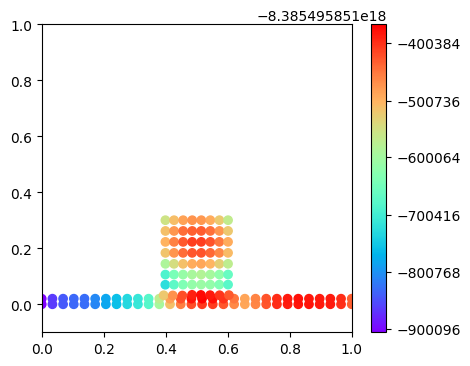

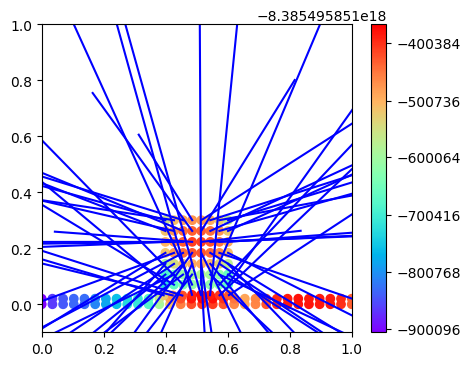

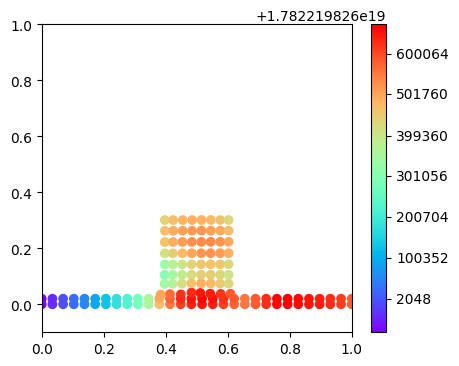

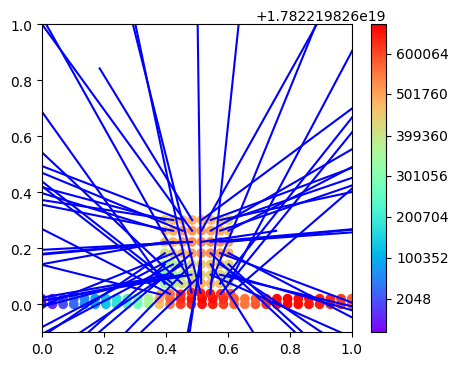

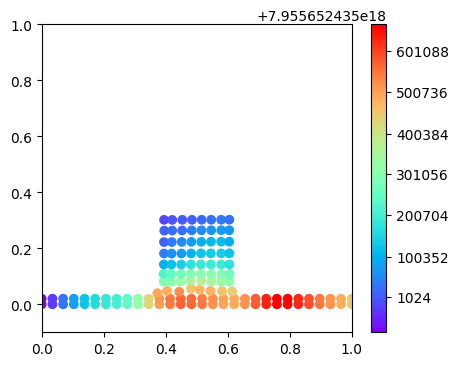

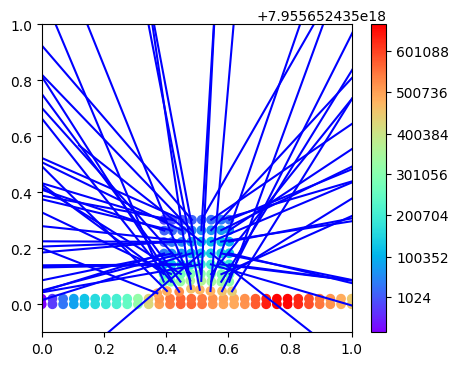

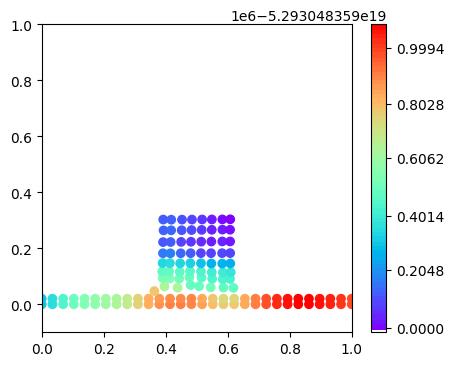

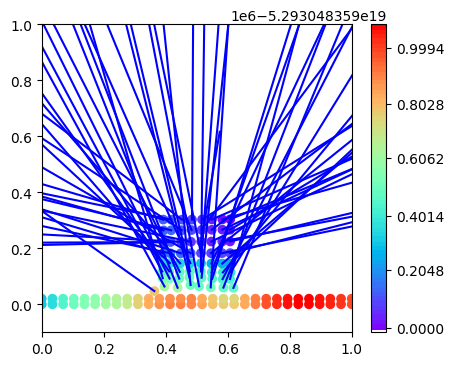

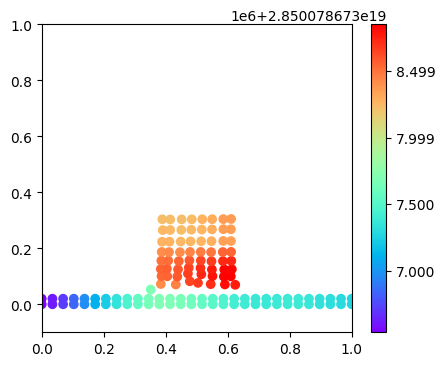

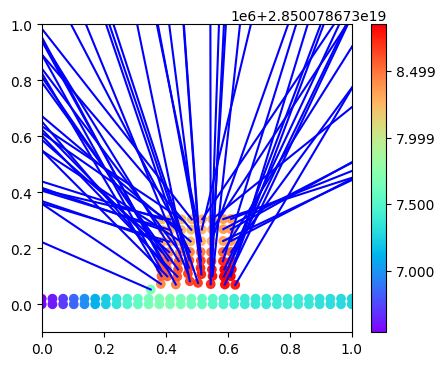

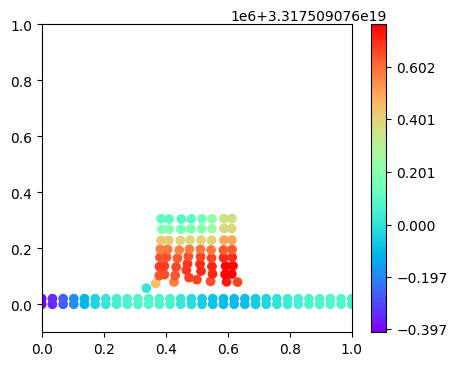

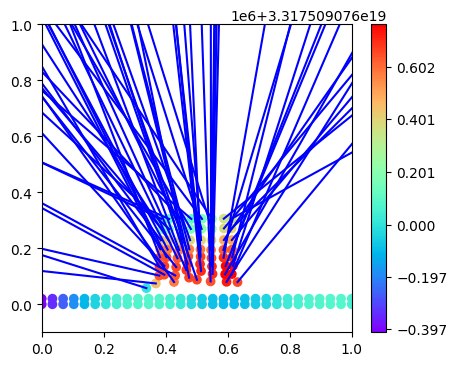

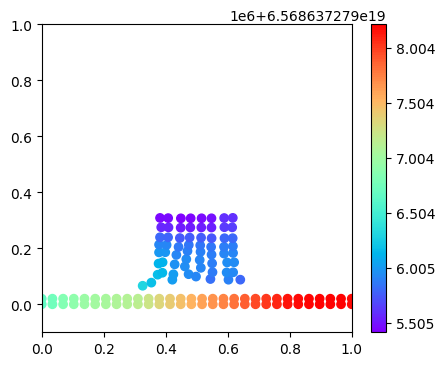

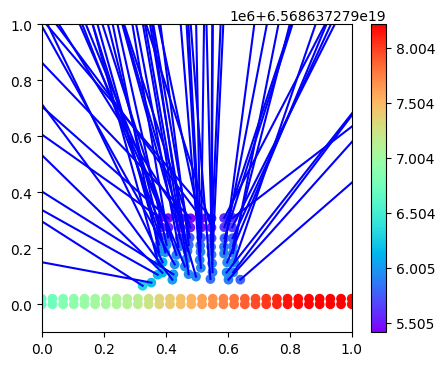

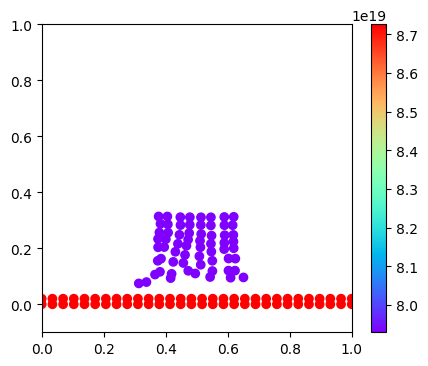

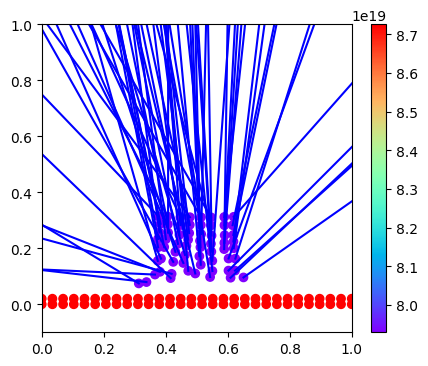

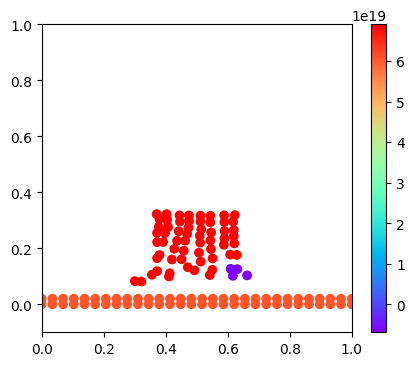

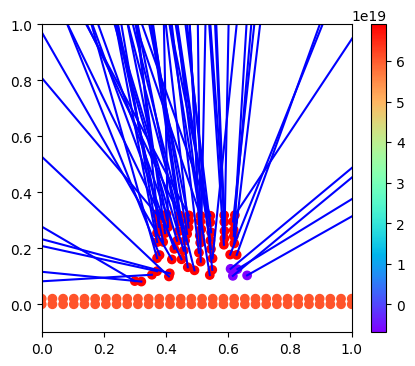

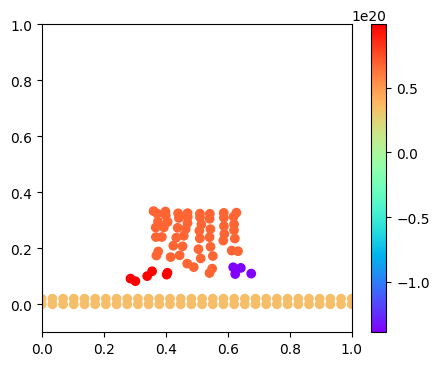

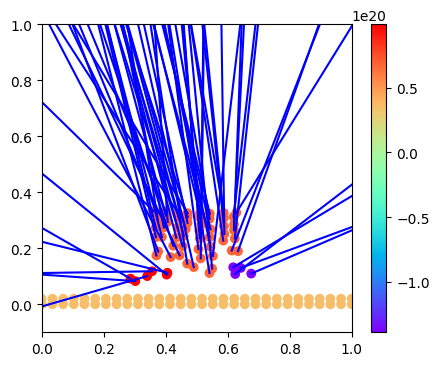

In [212]:
def plot_particle_(pos, vel=False, p=False):
    plt.scatter(*pos.T, c=p)
    plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.xlim(0,1)
    plt.ylim(0,1)


for i in range(0, 10, 1):
    pos=pos_timeseries[i]
    vel=vel_timeseries[i]
    p=p_timeseries[i]
    
    plt.figure(figsize=(5,4))
    plt.scatter(*pos.T, c=p, cmap="rainbow")
    #plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.colorbar()
    plt.xlim(0,1)
    plt.ylim(-0.1,1)
    
    plt.figure(figsize=(5,4))
    plt.scatter(*pos.T, c=p, cmap="rainbow")
    plt.plot(np.block([pos, pos+vel])[:, ::2].T, np.block([pos, pos+vel])[:, 1::2].T, c='blue')
    plt.colorbar()
    plt.xlim(0,1)
    plt.ylim(-0.1,1)

In [187]:
p_timeseries[5]

array([ 3.77656311e+38,  3.77656306e+38,  3.77656211e+38,  3.77656251e+38,
        3.77656213e+38,  3.77656313e+38,  3.77656244e+38,  3.77656250e+38,
        3.77656264e+38,  3.77656242e+38,  3.77656228e+38,  3.77656282e+38,
        3.77656220e+38,  3.77656285e+38,  3.77656468e+38,  3.77656454e+38,
        3.77656455e+38,  3.77656455e+38,  3.77656455e+38,  3.77656455e+38,
        3.77656454e+38,  3.77656454e+38,  3.77656455e+38,  3.77656454e+38,
        3.77656452e+38,  3.77656454e+38,  3.77656454e+38,  3.77656452e+38,
        3.77656454e+38,  3.77656452e+38,  3.77656271e+38,  3.77656275e+38,
        3.77656246e+38,  3.77656206e+38,  3.77656244e+38,  3.77656268e+38,
        3.77656213e+38,  3.77656328e+38,  3.77656205e+38,  3.77656269e+38,
        3.77656284e+38,  3.77656266e+38,  3.77656255e+38,  3.77656270e+38,
        3.77656465e+38,  3.77656454e+38,  3.77656452e+38,  3.77656453e+38,
        3.77656453e+38,  3.77656455e+38,  3.77656455e+38,  3.77656454e+38,
        3.77656454e+38,  